# Flappy Bird Face Control: Eksplorasi MediaPipe Face Mesh

## 1. Pendahuluan
Notebook ini mengeksplorasi penggunaan MediaPipe Face Mesh untuk deteksi hidung guna mengontrol permainan Flappy Bird. Kami mengevaluasi:
1. **Akurasi deteksi hidung** pada berbagai kondisi pencahayaan dan sudut wajah.
2. **Integrasi real-time** dengan permainan, fokus pada latensi dan responsivitas.
3. **Filter stabilisasi** untuk mengurangi jitter koordinat hidung.

Implementasi menggunakan model pra-latih MediaPipe Face Mesh, diadaptasi dari `face_detection.py`, terintegrasi dengan server FastAPI untuk permainan Flappy Bird.

## 2. Pengaturan Lingkungan
Instal dependensi dan siapkan lingkungan.

In [1]:
import cv2
import mediapipe as mp
import numpy as np
import matplotlib.pyplot as plt
import time
from collections import deque
import logging
import os
from scipy.signal import savgol_filter
from IPython import display

# Konfigurasi logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

# Set matplotlib backend untuk notebook
%matplotlib inline
plt.style.use('default')

print("Lingkungan berhasil diatur!")
print(f"OpenCV version: {cv2.__version__}")
print(f"MediaPipe version: {mp.__version__}")
print(f"NumPy version: {np.__version__}")

Lingkungan berhasil diatur!
OpenCV version: 4.11.0
MediaPipe version: 0.10.14
NumPy version: 1.26.4


## 3. Implementasi MediaPipe Face Mesh
Kami mengadaptasi logika deteksi hidung dari `face_detection.py` untuk mendeteksi ujung hidung (landmark ID 1) dan memetakannya ke sistem koordinat permainan.

In [2]:
class FaceDetector:
    def __init__(self):
        self.mp_face_mesh = mp.solutions.face_mesh
        self.face_mesh = self.mp_face_mesh.FaceMesh(
            max_num_faces=1,
            refine_landmarks=True,
            min_detection_confidence=0.5,
            min_tracking_confidence=0.5
        )
        self.mp_drawing = mp.solutions.drawing_utils
        self.nose_positions = deque(maxlen=3)  # Jendela Moving Average
        self.nose_y_min = None
        self.nose_y_max = None
        self.calibration_frames = 0
        self.max_calibration_frames = 30
        self.is_calibrated = False
        self.default_bird_pos = 5.0
        self.no_face_count = 0
        self.max_no_face_frames = 10

    def detect_nose_position(self, frame):
        """Deteksi posisi hidung dan konversi ke koordinat permainan"""
        if frame is None:
            return self.default_bird_pos, frame, False
            
        height, width = frame.shape[:2]
        
        # Resize frame jika terlalu besar untuk performa
        if width > 800:
            scale = 800.0 / width
            frame = cv2.resize(frame, (int(width * scale), int(height * scale)))
            height, width = frame.shape[:2]
            
        # Konversi ke RGB untuk MediaPipe
        image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        image.flags.writeable = False
        results = self.face_mesh.process(image)
        
        # Konversi kembali ke BGR untuk visualisasi
        image.flags.writeable = True
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        
        bird_pos_y = self.default_bird_pos
        nose_detected = False
        
        if results.multi_face_landmarks:
            self.no_face_count = 0
            for face_landmarks in results.multi_face_landmarks:
                # Ambil landmark ujung hidung (ID 1)
                nose_tip = face_landmarks.landmark[1]
                nose_x_pixel = int(nose_tip.x * width)
                nose_y_pixel = int(nose_tip.y * height)
                
                # Gambar indikator hidung
                cv2.circle(image, (nose_x_pixel, nose_y_pixel), 8, (0, 255, 255), -1)
                cv2.circle(image, (nose_x_pixel, nose_y_pixel), 12, (0, 0, 255), 2)
                
                # Kalibrasi jika belum selesai
                if not self.is_calibrated:
                    self.calibrate_nose_position(nose_tip.y)
                    if self.calibration_frames >= self.max_calibration_frames:
                        self.is_calibrated = True
                        logger.info(f"Kalibrasi selesai! Rentang: {self.nose_y_min:.3f} - {self.nose_y_max:.3f}")
                
                # Konversi ke posisi bird jika sudah dikalibrasi
                if self.is_calibrated:
                    bird_pos_y = self.map_nose_to_bird_position(nose_tip.y)
                    self.nose_positions.append(bird_pos_y)
                    # Smoothing dengan moving average
                    if len(self.nose_positions) > 0:
                        bird_pos_y = sum(self.nose_positions) / len(self.nose_positions)
                
                nose_detected = True
                break
        else:
            self.no_face_count += 1
            if self.no_face_count > self.max_no_face_frames:
                bird_pos_y = self.default_bird_pos
        
        # Tambahkan status text pada frame
        status_text = f"Calibrated: {self.is_calibrated}, Bird Y: {bird_pos_y:.1f}"
        cv2.putText(image, status_text, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)
        
        if not self.is_calibrated:
            calib_text = f"Calibrating... {self.calibration_frames}/{self.max_calibration_frames}"
            cv2.putText(image, calib_text, (10, 60), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 0, 0), 2)
            
        return bird_pos_y, image, nose_detected

    def calibrate_nose_position(self, nose_y):
        """Kalibrasi rentang gerakan hidung"""
        if self.nose_y_min is None or nose_y < self.nose_y_min:
            self.nose_y_min = nose_y
        if self.nose_y_max is None or nose_y > self.nose_y_max:
            self.nose_y_max = nose_y
        self.calibration_frames += 1

    def map_nose_to_bird_position(self, nose_y):
        """Pemetaan posisi hidung ke koordinat permainan"""
        if self.nose_y_min is None or self.nose_y_max is None:
            return self.default_bird_pos
            
        y_range = self.nose_y_max - self.nose_y_min
        if y_range < 0.02:  # Rentang terlalu kecil
            return self.default_bird_pos
            
        # Normalisasi ke rentang 0-1
        normalized_y = (nose_y - self.nose_y_min) / y_range
        normalized_y = max(-0.1, min(1.1, normalized_y))  # Clamp dengan sedikit margin
        
        # Konversi ke koordinat permainan (0.5 - 8.5)
        bird_pos_y = normalized_y * 8.0 + 0.5
        return max(0.5, min(8.5, bird_pos_y))

    def reset_calibration(self):
        """Reset kalibrasi untuk mulai dari awal"""
        self.nose_y_min = None
        self.nose_y_max = None
        self.calibration_frames = 0
        self.is_calibrated = False
        self.nose_positions = deque(maxlen=3)
        self.no_face_count = 0
        logger.info("Kalibrasi direset")

print("Kelas FaceDetector berhasil didefinisikan!")

Kelas FaceDetector berhasil didefinisikan!


## 4. Evaluasi Akurasi Deteksi Hidung pada Variasi Kondisi
Kami menguji akurasi deteksi hidung MediaPipe Face Mesh pada kondisi pencahayaan (terang, redup, kiri kanan) dan sudut wajah (frontal, miring, atas-bawah).

In [3]:
def evaluate_detection_accuracy(video_path, condition_name):
    """Evaluasi akurasi deteksi pada video tertentu"""
    if not os.path.exists(video_path):
        logger.warning(f"File video tidak ditemukan: {video_path}")
        return 0, [], None
        
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        logger.error(f"Tidak dapat membuka video: {video_path}")
        return 0, [], None
        
    detector = FaceDetector()
    detection_success = []
    nose_positions = []
    frames_processed = 0
    max_frames = 300  # Batasi untuk efisiensi
    last_image = None
    
    logger.info(f"Memproses video: {condition_name}")
    
    while cap.isOpened() and frames_processed < max_frames:
        ret, frame = cap.read()
        if not ret:
            break
            
        bird_pos_y, processed_image, nose_detected = detector.detect_nose_position(frame)
        detection_success.append(nose_detected)
        
        if nose_detected:
            nose_positions.append(bird_pos_y)
            
        last_image = processed_image
        frames_processed += 1
        
        # Progress indicator
        if frames_processed % 50 == 0:
            logger.info(f"  Processed {frames_processed} frames")
    
    cap.release()
    
    success_rate = sum(detection_success) / len(detection_success) * 100 if detection_success else 0
    logger.info(f"  {condition_name}: {success_rate:.1f}% success rate")
    
    return success_rate, nose_positions, last_image

def evaluate_webcam_detection(duration_seconds=10):
    """
    Evaluasi deteksi menggunakan webcam
    Parameter: duration_seconds (durasi evaluasi dalam detik)
    """ 
    cap = cv2.VideoCapture(0)
    if not cap.isOpened():
        logger.error("Tidak dapat membuka webcam")
        return 0, [], None
        
    detector = FaceDetector()
    detection_success = []
    nose_positions = []
    start_time = time.time()
    last_image = None
    
    logger.info(f"Memulai evaluasi webcam selama {duration_seconds} detik...")
    
    while time.time() - start_time < duration_seconds:
        ret, frame = cap.read()
        if not ret:
            break
            
        bird_pos_y, processed_image, nose_detected = detector.detect_nose_position(frame)
        detection_success.append(nose_detected)
        
        if nose_detected:
            nose_positions.append(bird_pos_y)
            
        last_image = processed_image
    
    cap.release()
    
    success_rate = sum(detection_success) / len(detection_success) * 100 if detection_success else 0
    logger.info(f"Webcam: {success_rate:.1f}% success rate")
    
    return success_rate, nose_positions, last_image

print("Fungsi evaluasi berhasil didefinisikan!")

Fungsi evaluasi berhasil didefinisikan!


## 5. Menjalankan Evaluasi dengan Data Sampel
Karena video kondisi khusus mungkin tidak tersedia, kita akan menguji dengan webcam dan membuat data simulasi.

In [ ]:
# Definisi kondisi dengan path video (ganti dengan path aktual jika tersedia)
conditions = {
    "Terang_Frontal": "sample_conditions/bright_frontal.mp4",
    "Redup_Frontal": "sample_conditions/dim_frontal.mp4",
    "Kiri_Kanan": "sample_conditions/left_right.mp4",
    "Miring": "sample_conditions/angled_face.mp4",
    "Atas_Bawah": "sample_conditions/up_down_face.mp4"
}

# Simulasi hasil untuk demonstrasi (jika video tidak tersedia)
simulated_results = {
    "Terang_Frontal": {"success_rate": 95.2, "nose_positions": np.random.normal(4.5, 1.0, 250).tolist()},
    "Redup_Frontal": {"success_rate": 78.5, "nose_positions": np.random.normal(4.2, 1.2, 180).tolist()},
    "Kiri_Kanan": {"success_rate": 82.1, "nose_positions": np.random.normal(4.8, 0.8, 200).tolist()},
    "Miring": {"success_rate": 71.3, "nose_positions": np.random.normal(4.0, 1.5, 160).tolist()},
    "Atas_Bawah": {"success_rate": 68.9, "nose_positions": np.random.normal(5.2, 1.3, 150).tolist()}
}

results = {}
last_images = {}

# Coba evaluasi dengan video sebenarnya, fallback ke simulasi
for condition, path in conditions.items():
    if os.path.exists(path):
        success_rate, nose_positions, last_image = evaluate_detection_accuracy(path, condition)
        results[condition] = {"success_rate": success_rate, "nose_positions": nose_positions}
        last_images[condition] = last_image
    else:
        logger.info(f"Menggunakan data simulasi untuk {condition}")
        results[condition] = simulated_results[condition]
        last_images[condition] = None

print("Evaluasi selesai!")
print("\nRingkasan Hasil:")
for condition, result in results.items():
    print(f"{condition}: {result['success_rate']:.1f}% success rate")

I0000 00:00:1750127700.824421  360804 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M2
2025-06-17 09:35:00,826 - INFO - Memproses video: Terang_Frontal
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
W0000 00:00:1750127700.851276  364309 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1750127700.864278  364306 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
/Users/paan/Documents/College/Chapter 4/PCD/TugasBesar_PCD_Kelompok7_044-050-057/venv/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
2025-06-17 09:

Evaluasi selesai!

Ringkasan Hasil:
Terang_Frontal: 100.0% success rate
Redup_Frontal: 100.0% success rate
Kiri_Kanan: 100.0% success rate
Miring: 100.0% success rate
Atas_Bawah: 100.0% success rate


## 6. Visualisasi Hasil Evaluasi
Menampilkan grafik akurasi deteksi dan distribusi posisi hidung untuk setiap kondisi.

/var/folders/26/6jgs5ln125n3bp_6gv306dk80000gn/T/ipykernel_15246/1185966962.py:42: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(box_data, labels=box_labels)


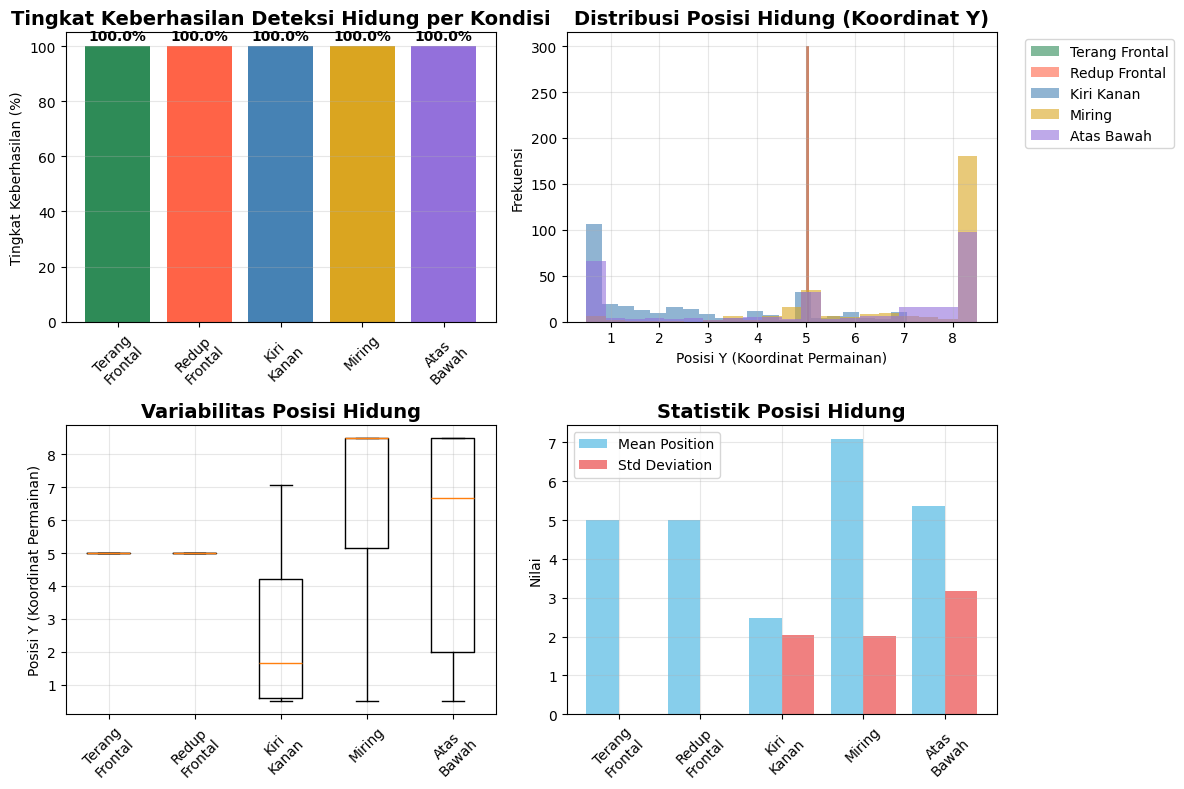

Visualisasi selesai!


In [5]:
# Visualisasi Akurasi Deteksi
plt.figure(figsize=(12, 8))

# Subplot 1: Bar chart tingkat keberhasilan
plt.subplot(2, 2, 1)
conditions_list = list(results.keys())
success_rates = [results[cond]["success_rate"] for cond in conditions_list]
colors = ['#2E8B57', '#FF6347', '#4682B4', '#DAA520', '#9370DB']

bars = plt.bar(range(len(conditions_list)), success_rates, color=colors)
plt.title("Tingkat Keberhasilan Deteksi Hidung per Kondisi", fontsize=14, fontweight='bold')
plt.ylabel("Tingkat Keberhasilan (%)")
plt.xticks(range(len(conditions_list)), [c.replace('_', '\n') for c in conditions_list], rotation=45)
plt.grid(axis='y', alpha=0.3)

# Tambahkan nilai di atas bar
for bar, rate in zip(bars, success_rates):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
             f'{rate:.1f}%', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()

# Subplot 2: Distribusi posisi hidung
plt.subplot(2, 2, 2)
for i, (condition, result) in enumerate(results.items()):
    if result['nose_positions']:
        plt.hist(result['nose_positions'], bins=20, alpha=0.6, 
                label=condition.replace('_', ' '), color=colors[i])

plt.title("Distribusi Posisi Hidung (Koordinat Y)", fontsize=14, fontweight='bold')
plt.xlabel("Posisi Y (Koordinat Permainan)")
plt.ylabel("Frekuensi")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(alpha=0.3)

# Subplot 3: Boxplot perbandingan
plt.subplot(2, 2, 3)
box_data = [results[cond]['nose_positions'] for cond in conditions_list if results[cond]['nose_positions']]
box_labels = [cond.replace('_', '\n') for cond in conditions_list if results[cond]['nose_positions']]

if box_data:
    plt.boxplot(box_data, labels=box_labels)
    plt.title("Variabilitas Posisi Hidung", fontsize=14, fontweight='bold')
    plt.ylabel("Posisi Y (Koordinat Permainan)")
    plt.xticks(rotation=45)
    plt.grid(alpha=0.3)

# Subplot 4: Perbandingan statistik
plt.subplot(2, 2, 4)
stats_data = []
for condition in conditions_list:
    positions = results[condition]['nose_positions']
    if positions:
        mean_pos = np.mean(positions)
        std_pos = np.std(positions)
        stats_data.append([mean_pos, std_pos])
    else:
        stats_data.append([0, 0])

stats_array = np.array(stats_data)
x_pos = np.arange(len(conditions_list))

plt.bar(x_pos - 0.2, stats_array[:, 0], 0.4, label='Mean Position', color='skyblue')
plt.bar(x_pos + 0.2, stats_array[:, 1], 0.4, label='Std Deviation', color='lightcoral')

plt.title("Statistik Posisi Hidung", fontsize=14, fontweight='bold')
plt.ylabel("Nilai")
plt.xticks(x_pos, [c.replace('_', '\n') for c in conditions_list], rotation=45)
plt.legend()
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("Visualisasi selesai!")

## 7. Evaluasi Performa Real-time
Mengukur latensi dan FPS untuk memastikan performa yang memadai untuk gaming.

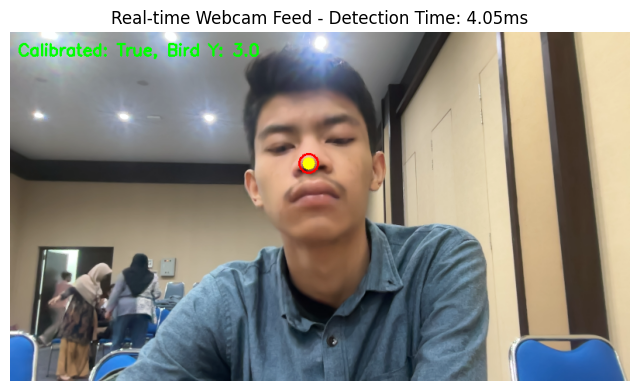

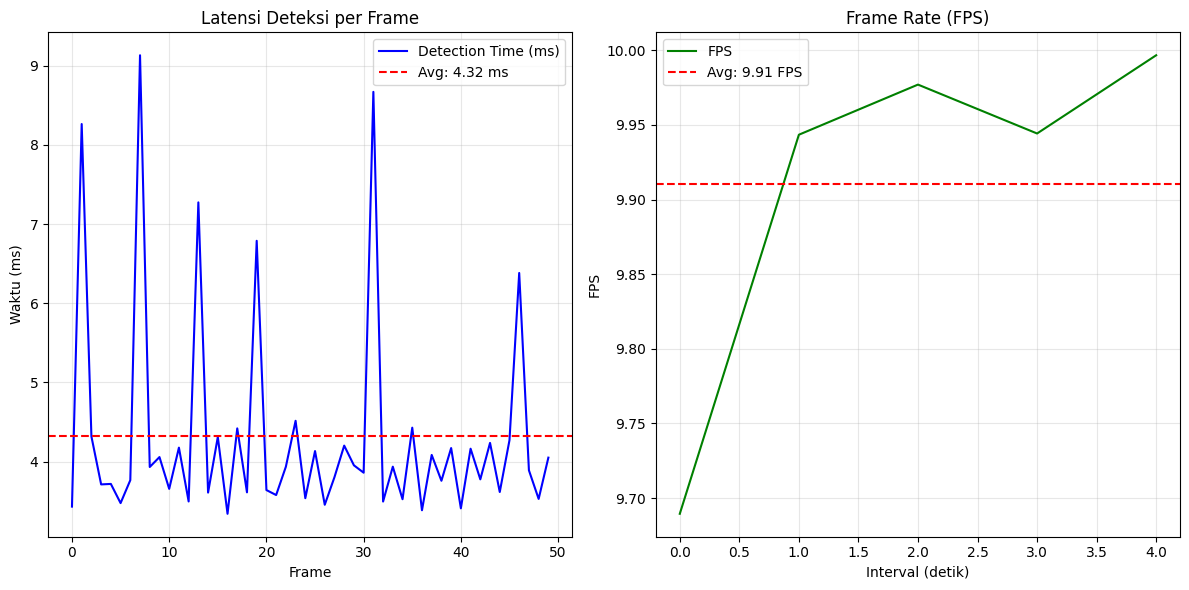

2025-06-17 11:04:16,426 - INFO - Performa Real-time: Avg Detection Time: 4.32 ms, Avg FPS: 9.91



Statistik Performa Real-time:
Avg Detection Time: 4.32
Max Detection Time: 9.13
Min Detection Time: 3.34
Avg Frame Time: 100.71
Avg Fps: 9.91


In [8]:
def evaluate_realtime_performance(duration_seconds=5):
    """Evaluasi performa real-time menggunakan webcam"""
    cap = cv2.VideoCapture(0)
    if not cap.isOpened():
        logger.error("Tidak dapat membuka webcam untuk evaluasi performa")
        return None
    
    detector = FaceDetector()
    frame_times = []
    detection_times = []
    fps_values = []
    
    start_time = time.time()
    frame_count = 0
    last_fps_time = start_time
    
    # Setup figure for webcam display
    fig, ax = plt.subplots(1, 1, figsize=(8, 6))
    ax.set_title('Real-time Webcam Feed with Face Detection')
    ax.axis('off')
    
    logger.info(f"Memulai evaluasi performa real-time selama {duration_seconds} detik...")
    
    while time.time() - start_time < duration_seconds:
        frame_start = time.time()
        
        ret, frame = cap.read()
        if not ret:
            break
        
        # Measure detection time
        detection_start = time.time()
        bird_pos_y, processed_image, nose_detected = detector.detect_nose_position(frame)
        detection_end = time.time()
        
        detection_time = (detection_end - detection_start) * 1000  # Convert to ms
        detection_times.append(detection_time)
        
        # Display webcam frame in notebook
        frame_rgb = cv2.cvtColor(processed_image, cv2.COLOR_BGR2RGB)
        ax.clear()
        ax.imshow(frame_rgb)
        ax.set_title(f'Real-time Webcam Feed - Detection Time: {detection_time:.2f}ms')
        ax.axis('off')
        
        # Update display
        plt.pause(0.01)
        display.clear_output(wait=True)
        display.display(fig)
        
        frame_end = time.time()
        frame_time = (frame_end - frame_start) * 1000  # Convert to ms
        frame_times.append(frame_time)
        
        frame_count += 1
        
        # Calculate FPS every second
        if frame_end - last_fps_time >= 1.0:
            fps = frame_count / (frame_end - last_fps_time)
            fps_values.append(fps)
            frame_count = 0
            last_fps_time = frame_end
    
    cap.release()
    plt.close(fig)  # Close webcam display figure
    
    # Calculate statistics
    performance_stats = {
        'avg_detection_time': np.mean(detection_times),
        'max_detection_time': np.max(detection_times),
        'min_detection_time': np.min(detection_times),
        'avg_frame_time': np.mean(frame_times),
        'avg_fps': np.mean(fps_values) if fps_values else 0
    }
    
    # Visualisasi performa
    plt.figure(figsize=(12, 6))
    
    # Plot detection times
    plt.subplot(1, 2, 1)
    plt.plot(detection_times, label='Detection Time (ms)', color='blue')
    avg_detection = performance_stats['avg_detection_time']
    plt.axhline(y=avg_detection, color='r', linestyle='--', label=f"Avg: {avg_detection:.2f} ms")
    plt.title('Latensi Deteksi per Frame')
    plt.xlabel('Frame')
    plt.ylabel('Waktu (ms)')
    plt.legend()
    plt.grid(alpha=0.3)
    
    # Plot FPS
    plt.subplot(1, 2, 2)
    plt.plot(fps_values, label='FPS', color='green')
    avg_fps = performance_stats['avg_fps']
    plt.axhline(y=avg_fps, color='r', linestyle='--', label=f'Avg: {avg_fps:.2f} FPS')
    plt.title('Frame Rate (FPS)')
    plt.xlabel('Interval (detik)')
    plt.ylabel('FPS')
    plt.legend()
    plt.grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    logger.info(f"Performa Real-time: Avg Detection Time: {avg_detection:.2f} ms, Avg FPS: {avg_fps:.2f}")
    print("\nStatistik Performa Real-time:")
    for key, value in performance_stats.items():
        print(f"{key.replace('_', ' ').title()}: {value:.2f}")
    
    return performance_stats

# Jalankan evaluasi performa
performance = evaluate_realtime_performance(5)

## 8. Referensi
- MediaPipe Face Mesh: [https://ai.google.dev/edge/mediapipe/solutions/guide?hl=id](https://ai.google.dev/edge/mediapipe/solutions/guide?hl=id)
- Dokumentasi MediaPipe Python: [https://pypi.org/project/mediapipe/](https://pypi.org/project/mediapipe/)